# Preparation

In [1]:
# Import primary function libraries
import catboost
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import secondary function libraries
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve, RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the data

In [2]:
# Data loading
train=pd.read_csv('/kaggle/input/playground-series-s5e11/train.csv')
test=pd.read_csv('/kaggle/input/playground-series-s5e11/test.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

df=train.copy()
df=df.drop('id', axis=1)

Train shape: (593994, 13)
Test shape: (254569, 12)


# Exploratory Data Analysis

In [3]:
# Value counts
df.dtypes.value_counts()

object     6
float64    5
int64      1
Name: count, dtype: int64

In [4]:
# Null inputs
df.isnull().sum()

annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64

In [5]:
# Show first five rows of the dataset
df.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [6]:
# Normalize the 'loan_paid_back' dataset feature
df['loan_paid_back'].value_counts(normalize=True)

loan_paid_back
1.0    0.79882
0.0    0.20118
Name: proportion, dtype: float64

# Correlation Analysis

In [7]:
# Define numerical features of the dataset's column
numerical_col=[
    'annual_income',
    'debt_to_income_ratio',
    'credit_score',
    'loan_amount',
    'interest_rate'
]

<Axes: >

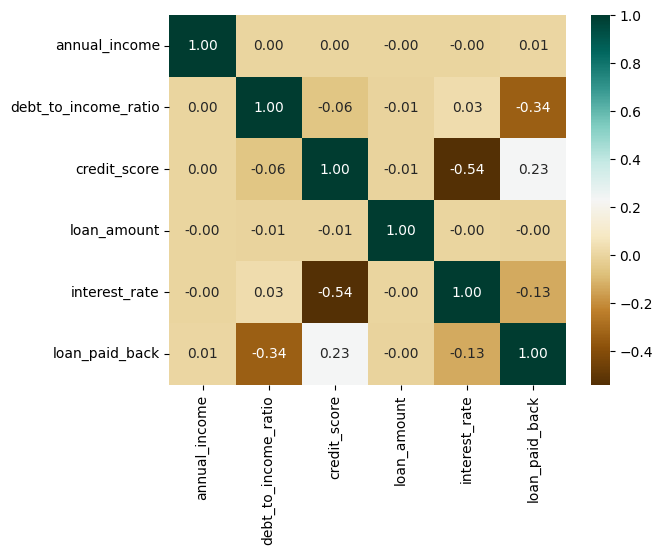

In [8]:
# Generate heatmap
sns.heatmap(
    df[numerical_col + ['loan_paid_back']].corr(),
    annot=True,
    fmt='.2f',
    cmap='BrBG'
)

In [10]:
# Outliers detection
for col in numerical_col:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
    outlier_pct = (outliers / len(df)) * 100
    print(f"{col:25} {outliers:7,} outliers ({outlier_pct:5.2f}%)")

annual_income              15,917 outliers ( 2.68%)
debt_to_income_ratio       17,556 outliers ( 2.96%)
credit_score                5,901 outliers ( 0.99%)
loan_amount                 2,902 outliers ( 0.49%)
interest_rate               5,136 outliers ( 0.86%)


# Categorical Variable Analysis

In [11]:
# Define categorical features of the dataset's column
categorical_col=[
    'gender',
    'marital_status',
    'education_level',
    'employment_status',
    'loan_purpose',
    'grade_subgrade'
]

for col in categorical_col:
    crosstab = pd.crosstab(df[col], df['loan_paid_back'], normalize='index')
    print(f"\n{col}: ")
    print(crosstab.round(2))


gender: 
loan_paid_back  0.0  1.0
gender                  
Female          0.2  0.8
Male            0.2  0.8
Other           0.2  0.8

marital_status: 
loan_paid_back   0.0   1.0
marital_status            
Divorced        0.20  0.80
Married         0.20  0.80
Single          0.20  0.80
Widowed         0.21  0.79

education_level: 
loan_paid_back    0.0   1.0
education_level            
Bachelor's       0.21  0.79
High School      0.19  0.81
Master's         0.20  0.80
Other            0.20  0.80
PhD              0.17  0.83

employment_status: 
loan_paid_back      0.0   1.0
employment_status            
Employed           0.11  0.89
Retired            0.00  1.00
Self-employed      0.10  0.90
Student            0.74  0.26
Unemployed         0.92  0.08

loan_purpose: 
loan_paid_back       0.0   1.0
loan_purpose                  
Business            0.19  0.81
Car                 0.20  0.80
Debt consolidation  0.20  0.80
Education           0.22  0.78
Home                0.18  0.82
Medica

# Feature engineering

In [12]:
def encode_grade(df):
    df['grade']=df['grade_subgrade'].str[0]
    df=df.drop('grade_subgrade', axis=1)
    grade_map={
        'F': 1,
        'E': 2,
        'D': 3,
        'C': 4,
        'B': 5,
        'A': 6
    }
    df['grade']=df['grade'].map(grade_map)
    return df

def encode_education(df):
    education_map={
        'Other': 1,
        'High School': 2,
        'Bachelors': 3,
        'Masters': 4,
        'PhD': 5
    }
    df['education_level']=df['education_level'].map(education_map)
    return df

In [13]:
def drop_useless_columns(df):
    df=df.drop(['marital_status', 'gender'], axis=1)
    return df

In [14]:
def encode_categorical(df):
    df=pd.get_dummies(
        df,
        columns=['employment_status', 'loan_purpose'],
        drop_first=True,
        dtype=int
    )
    return df

In [16]:
def preprocessing(df):
    df=df.copy()
    df=encode_grade(df)
    df=encode_education(df)
    df=encode_categorical(df)
    df=drop_useless_columns(df)

    X=df.drop('loan_paid_back', axis=1)
    y=df['loan_paid_back']

    print(y.value_counts())

    return X, y

X, y = preprocessing(df)

loan_paid_back
1.0    474494
0.0    119500
Name: count, dtype: int64


In [17]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [18]:
X_train.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,education_level,grade,employment_status_Retired,employment_status_Self-employed,employment_status_Student,employment_status_Unemployed,loan_purpose_Car,loan_purpose_Debt consolidation,loan_purpose_Education,loan_purpose_Home,loan_purpose_Medical,loan_purpose_Other,loan_purpose_Vacation
100143,92432.16,0.067,636,14369.05,13.78,NaN,3,0,0,0,0,0,1,0,0,0,0,0
560097,28850.38,0.122,643,8471.26,14.40,2.0,3,0,0,0,0,0,1,0,0,0,0,0
356847,39427.43,0.041,672,7647.50,11.99,2.0,4,0,0,0,0,0,1,0,0,0,0,0
150444,71644.31,0.208,646,7125.57,12.19,2.0,3,0,0,0,1,1,0,0,0,0,0,0
550361,69010.47,0.186,708,10659.02,15.09,NaN,4,0,0,0,0,0,0,0,0,1,0,0


In [19]:
X_train.describe()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,education_level,grade,employment_status_Retired,employment_status_Self-employed,employment_status_Student,employment_status_Unemployed,loan_purpose_Car,loan_purpose_Debt consolidation,loan_purpose_Education,loan_purpose_Home,loan_purpose_Medical,loan_purpose_Other,loan_purpose_Vacation
count,475195.000000,475195.000000,475195.000000,475195.000000,475195.000000,177084.000000,475195.000000,475195.000000,475195.000000,475195.000000,475195.000000,475195.000000,475195.000000,475195.000000,475195.000000,475195.000000,475195.000000,475195.000000
mean,48221.737087,0.120632,680.918497,15025.190161,12.357129,2.028162,3.604194,0.027742,0.088025,0.020129,0.105245,0.097514,0.546723,0.061909,0.074323,0.038431,0.107219,0.014316
std,26733.808141,0.068478,55.407560,6929.253596,2.007715,0.752838,0.985029,0.164234,0.283331,0.140440,0.306869,0.296656,0.497813,0.240991,0.262296,0.192233,0.309392,0.118791
min,6002.430000,0.011000,395.000000,500.370000,3.320000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27920.860000,0.072000,646.000000,10279.040000,10.990000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,46621.540000,0.096000,682.000000,15000.220000,12.370000,2.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,60981.320000,0.156000,719.000000,18870.480000,13.680000,2.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,393381.740000,0.577000,849.000000,48959.950000,20.990000,5.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Model training

In [20]:
# Model selection: CatBoost classifier
model = CatBoostClassifier(
    iterations=1500,
    learning_rate=0.15,
    depth=4,
    class_weights={0:3, 1:1},
    eval_metric='AUC',
    l2_leaf_reg=9,
    random_seed=42,
    loss_function='Logloss',
    verbose=100
)

model.fit(X_train, y_train)

0:	total: 101ms	remaining: 2m 31s
100:	total: 4.09s	remaining: 56.7s
200:	total: 8.09s	remaining: 52.3s
300:	total: 12.1s	remaining: 48.3s
400:	total: 16.1s	remaining: 44.2s
500:	total: 20.2s	remaining: 40.2s
600:	total: 24.2s	remaining: 36.3s
700:	total: 28.4s	remaining: 32.3s
800:	total: 32.4s	remaining: 28.3s
900:	total: 36.5s	remaining: 24.3s
1000:	total: 40.7s	remaining: 20.3s
1100:	total: 44.8s	remaining: 16.2s
1200:	total: 48.9s	remaining: 12.2s
1300:	total: 53s	remaining: 8.1s
1400:	total: 57.1s	remaining: 4.03s
1499:	total: 1m 1s	remaining: 0us


# Evaluation

In [21]:
y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]
score = roc_auc_score(y_val, y_pred_proba)
cm = confusion_matrix(y_val, y_pred)

importance = model.get_feature_importance()
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
}).sort_values(
    'Importance',
    ascending=False
)

print(classification_report(y_val, y_pred))
print(score)
print(cm)
print(importance_df.to_string(index=False))

              precision    recall  f1-score   support

         0.0       0.70      0.76      0.73     23900
         1.0       0.94      0.92      0.93     94899

    accuracy                           0.89    118799
   macro avg       0.82      0.84      0.83    118799
weighted avg       0.89      0.89      0.89    118799

0.9236367142323213
[[18211  5689]
 [ 7808 87091]]
                        Feature  Importance
   employment_status_Unemployed   56.966247
           debt_to_income_ratio   18.483066
                   credit_score   10.124678
      employment_status_Student    4.459987
                          grade    2.957899
      employment_status_Retired    2.912575
                    loan_amount    1.345353
                  interest_rate    1.163091
                  annual_income    1.130321
                education_level    0.120116
             loan_purpose_Other    0.074350
employment_status_Self-employed    0.051534
loan_purpose_Debt consolidation    0.047378
       

# Submission

In [22]:
def preprocessing_test(df):
    df=df.copy()
    df=df.drop('id', axis=1)
    df=encode_grade(df)
    df=encode_education(df)
    df=encode_categorical(df)
    df=drop_useless_columns(df)
    
    return df

In [23]:
test_ids = test['id']
X_test = preprocessing_test(test)

X_full, y_full = preprocessing(df)

loan_paid_back
1.0    474494
0.0    119500
Name: count, dtype: int64


In [24]:
model_final = CatBoostClassifier(
    iterations=1500,
    learning_rate=0.15,
    depth=4,
    class_weights={0:3, 1:1},
    eval_metric='AUC',
    l2_leaf_reg=9,
    random_seed=42,
    loss_function='Logloss',
    verbose=100
)

model_final.fit(X_full, y_full)

0:	total: 59.1ms	remaining: 1m 28s
100:	total: 5.06s	remaining: 1m 10s
200:	total: 9.99s	remaining: 1m 4s
300:	total: 14.9s	remaining: 59.5s
400:	total: 20s	remaining: 54.8s
500:	total: 25s	remaining: 49.9s
600:	total: 30s	remaining: 44.9s
700:	total: 35.1s	remaining: 40s
800:	total: 40.1s	remaining: 35s
900:	total: 45.2s	remaining: 30.1s
1000:	total: 50.2s	remaining: 25s
1100:	total: 55.4s	remaining: 20.1s
1200:	total: 1m	remaining: 15.1s
1300:	total: 1m 5s	remaining: 10.1s
1400:	total: 1m 10s	remaining: 5.01s
1499:	total: 1m 15s	remaining: 0us


In [25]:
y_pred_proba = model_final.predict_proba(X_test)[:, 1]

In [27]:
submission = pd.DataFrame({
    'id': test_ids,
    'loan_paid_back': y_pred_proba
})

submission.to_csv('/kaggle/working/submission.csv', index=False)

print("Successfully saved as CSV file")

Successfully saved as CSV file
